In [1]:
import matplotlib.pyplot as plt
import pylab
import math
import copy
import os
import time
import warnings
import numpy as np


from IPython.display import clear_output

import sys
sys.path.append("C:\\Users\\artur\\Desktop\\QAE")

from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Charts import multi_plot_flat_ts, meas_plot
from qae_utils.Tools import draw_circuit
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
from qae_utils.Window import ts_calc_noise, ts_add_noise
from qae_utils.Files import read_pickle_file
from qae_utils.Files import write_pickle_file

In [2]:
import pennylane as qml
from pennylane import numpy as np

In [ ]:
# Load the Mackey-Glass data (same as Half-QAE)
DATA_PATH = '../Artur/aintern/data' 
DATA_NAME = 'mackey_glass'

data_folders = [f for f in os.listdir(DATA_PATH) if f.startswith(DATA_NAME)]

    
data_folder = data_folders[0]
print(f"Using data from: {data_folder}")
print(f"Full data path: {DATA_PATH}/{data_folder}")
    
X = read_ts_file(f'{DATA_PATH}/{data_folder}/x_org.arr')
y = read_ts_file(f'{DATA_PATH}/{data_folder}/y_org.arr')
    


Using data from: mackey_glass_n100
Full data path: ../Artur/aintern/data/mackey_glass_n100


In [4]:
### Run specific architectural + training param
#   These parameter values can be set from the test data

### Data params

samples = 100
split = 0.75
train_size = int(samples*split)     # Use the first train_size points for training
test_size = samples - train_size    # Use the next test_size points for testing

wind_size = 5
wind_step = 2
horizon = 1

noise = 0.1 # This is max absolute, in relation to value range (0, 1)

### Model params
rot = 'Rxyz' # Ry / Rxyz
n_layers = 3
n_latent = 3
n_extra = 2
n_epochs = 100 # 1000 # 2000
log_interv = 1
param_scaler = 0.1

### Derived params
n_trash = wind_size - n_latent
n_data = n_latent + n_trash
n_wires = n_latent + n_trash + n_extra

### Other (CASE_NAME) invariant params
diff_method = 'best'
interface = None # we will use default
level='gradient'
shuffle_interv = 0
cost_type = 'MSE'
cost_yscale = 'linear' # linear, log
shots = None # We use a state vector simulator

### Currently are not generated here, but QAE models should run 10 times with diff inits
#   The number of times the model should be run with different initial params
#   Each instance history and params should be saved and later used
n_inst = 1

### Random seed(s)
#   We may need to create different seeds for each model instance

seed = 2024

if seed == 0: 
    np.random.seed(rand_seed())
else:
    np.random.seed(seed)
inst_seeds = [int(n) for n in np.random.randint(0, high=9999, size=n_inst)]

### Quantum simulator
sim = 'default.qubit' 


np.random.seed(seed)

opt = qml.AdamOptimizer(stepsize=0.5)

In [5]:
### Create time series tensor data with optional noise (note that windows overlap by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2):
    y_ts = ts_wind_make(ts_add_noise(y, noise), wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(y_ts))])
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = np.tensor(X_train_ts, requires_grad=False)
    y_train_tens = np.tensor(y_train_ts, requires_grad=False)
    X_test_tens = np.tensor(X_test_ts, requires_grad=False)
    y_test_tens = np.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [6]:
def mse_denoising_cost_dynamic(model, params, pure_batch, noise_level):
    """
    Dynamically generate noise for each sample in the batch during training.
    Increases model robustness to different noise patterns.
    """
    cost = 0
    vals = 0
    for i in range(len(pure_batch)):
        noisy_input = ts_add_noise(pure_batch[i], noise_level)
        prediction = model(params, noisy_input)
        for w in range(len(pure_batch[i])):
            cost = cost + (pure_batch[i][w] - prediction[w]) ** 2
            vals += 1
    cost = cost / vals
    return cost

In [7]:
### Half QAE unified shape
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_layers: number of layers (repeats)
#   returns: shape
def half_qae_shape_unified(n_latent, n_trash, n_extra=0, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

In [8]:
def half_qae_unified(wires, n_latent, n_trash, n_layers=1, rot='Ry', dagger=False):
    latent_wires = wires[:n_latent]
    trash_wires  = wires[n_latent:n_latent+n_trash]
    data_wires   = latent_wires + trash_wires
    anz_wires    = data_wires

    def _sequence_encoder(wires, inputs):
        n_inputs = len(inputs)
        for w in wires:
            if w > n_inputs-1:
                qml.RY(0, wires=w)
            else:
                qml.RY(inputs[w], wires=w)

    def _entangler_shape(n_layers, n_wires, rot='Ry'):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return ()

    def _entangler(wires, weights, rot='Ry'):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=anz_wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=anz_wires)

    def _half_qae_unified(weights, inputs):
        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)
        shape = _entangler_shape(n_layers, len(anz_wires), rot=rot)
        w = weights.reshape(shape)
        if dagger:
            qml.adjoint(_entangler)(anz_wires, w, rot=rot)
            return [qml.expval(qml.PauliZ(w)) for w in latent_wires + trash_wires]
        else:
            _entangler(anz_wires, w, rot=rot)
            return [qml.expval(qml.PauliZ(w)) for w in latent_wires + trash_wires]

    return _half_qae_unified

In [9]:
##### Create a model

wires = list(range(n_latent + n_trash))

### Check the HALF QAE shape
shape = half_qae_shape_unified(n_latent, n_trash, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)
print(f'Half-QAE unified shape: {shape}, weights: {int(n_weights)}\n')
sample_params = np.random.uniform(high=param_scaler, size=shape, requires_grad=True)
sample_data = np.linspace(100, 200, n_latent + n_trash, requires_grad=False)

Half-QAE unified shape: (3, 5, 3), weights: 45



In [10]:
qae_pure = half_qae_unified(wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=False)
dev_pure = qml.device(sim, wires=wires, shots=shots, seed=seed)
half_qae_model_unified_pure = qml.QNode(qae_pure, dev_pure)

In [11]:
qae_noise = half_qae_unified(wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=False)
dev_noise = qml.device(sim, wires=wires, shots=shots, seed=seed)
half_qae_model_unified_noise = qml.QNode(qae_noise, dev_noise)

In [13]:
def train_with_noise_general(
    model, X, y, loss_fun, optimizer, n_epochs, init_weights=None, 
    log_interv=100, prompt_fract=0.1, start_time=0, level=2, seed=0,
    wind_size=8, wind_step=4, noise=0, weight_scaler=0.1, target_type="pure"
):
    """
    Universal training function supporting different target types:
    - "pure": uses pure data as targets.
    - "trash": uses pure data with additional zeros for trash qubits.
    - "latent": uses latent data as targets.
    """
    if seed == 0:
        seed = int(time.time() * 1000) % 10000
    np.random.seed(seed)
    
    # Prepare history
    hist_cost = []
    hist_params = []
    
    # Initialize weights
    if init_weights is None:
        init_weights = np.random.uniform(high=np.pi, size=shape, requires_grad=True) * weight_scaler
    params = init_weights.copy()
    
    # Prepare target tensors based on target_type
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)
    if target_type == "pure":
        targets = y_pure_tens
    elif target_type == "trash":
        y_trash_tens = np.zeros((len(y_pure_tens), n_trash))  # Trash qubits = 0
        targets = np.concatenate([y_pure_tens[:, :n_latent], y_trash_tens], axis=1)
    elif target_type == "latent":
        targets = np.array([half_qae_model_unified_pure(best_params_pure, window)[:n_latent] for window in y_train_pure_tens])
    else:
        raise ValueError(f"Unknown target type: {target_type}")

    if start_time == 0:
        start_time = time.time()
    
    # Training loop
    for iter in range(n_epochs):
        # Dynamically generate noise for each sample
        _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)
        params, cost = optimizer.step_and_cost(
            lambda p: loss_fun(model, p, targets, noise),
            params
        )
        elapsed_time = time.time() - start_time
        
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract * n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):03d} sec) cost={np.round(cost, 6)}')
    
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)
# ...existing code...

In [14]:
hist_cost, hist_params, init_weights, stats = train_with_noise_general(
    half_qae_model_unified_pure,
    X, y, mse_denoising_cost_dynamic, opt, n_epochs,
    wind_size=wind_size, wind_step=wind_step, noise=0,
    log_interv=log_interv, prompt_fract=0.1, start_time=0, seed=seed, target_type="trash"
)

Iter: 000 (002 sec) cost=0.148065
Iter: 010 (028 sec) cost=0.014528
Iter: 020 (052 sec) cost=0.008924
Iter: 030 (077 sec) cost=0.004729
Iter: 040 (101 sec) cost=0.002284
Iter: 050 (125 sec) cost=0.001387
Iter: 060 (149 sec) cost=0.000783
Iter: 070 (174 sec) cost=0.00114
Iter: 080 (199 sec) cost=0.001513
Iter: 090 (224 sec) cost=0.000404

Training completed: epochs=100, min cost=0.000312 @ 97, time=247 secs



In [15]:
best_params_pure = hist_params[stats[0]]

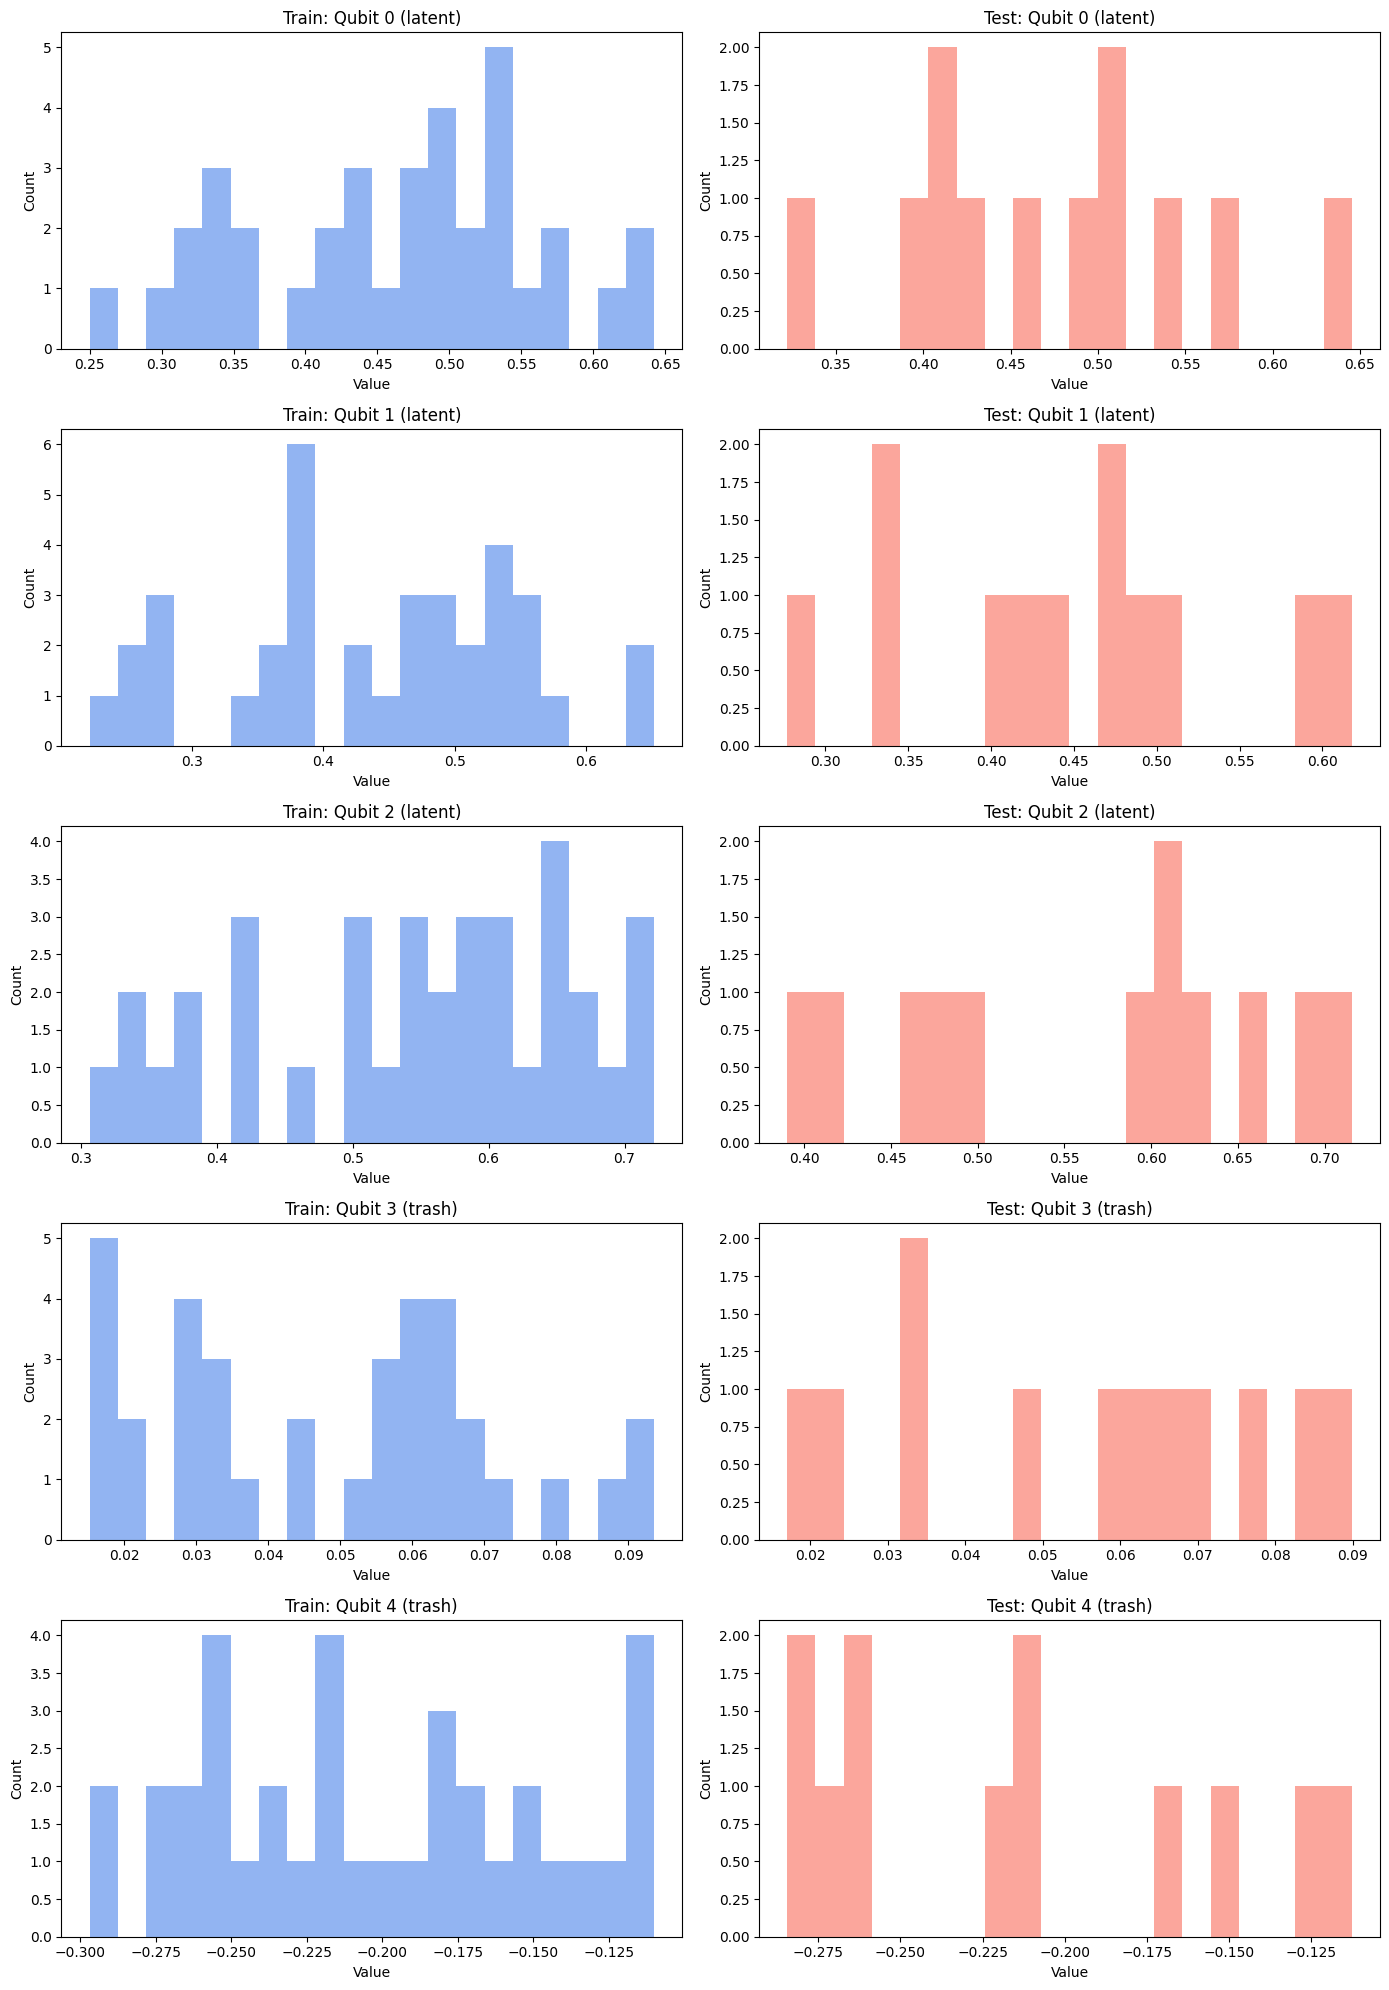

In [16]:
# Create the training and test tensors for pure data
_, y_train_pure_tens, _, y_test_pure_tens = create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)

# Run the model on training and test tensors
output_train = np.array([half_qae_model_unified_pure(best_params_pure, window) for window in y_train_pure_tens])
output_test = np.array([half_qae_model_unified_pure(best_params_pure, window) for window in y_test_pure_tens])

n_qubits = output_train.shape[1]

plt.figure(figsize=(14, 4 * n_qubits))
for i in range(n_qubits):
    plt.subplot(n_qubits, 2, 2*i+1)
    plt.hist(output_train[:, i], bins=20, alpha=0.7, color='cornflowerblue')
    plt.title(f'Train: Qubit {i} {"(latent)" if i < n_latent else "(trash)"}')
    plt.ylabel('Count')
    plt.xlabel('Value')
    plt.subplot(n_qubits, 2, 2*i+2)
    plt.hist(output_test[:, i], bins=20, alpha=0.7, color='salmon')
    plt.title(f'Test: Qubit {i} {"(latent)" if i < n_latent else "(trash)"}')
    plt.ylabel('Count')
    plt.xlabel('Value')
plt.tight_layout()

In [17]:
hist_cost, hist_params, init_weights, stats = train_with_noise_general(
    half_qae_model_unified_noise,
    X, y, mse_denoising_cost_dynamic, opt, n_epochs,
    wind_size=wind_size, wind_step=wind_step, noise=noise,
    log_interv=log_interv, prompt_fract=0.1, start_time=0, seed=seed, target_type="latent"
)

Iter: 000 (002 sec) cost=0.043424
Iter: 010 (028 sec) cost=0.006048
Iter: 020 (051 sec) cost=0.00472
Iter: 030 (077 sec) cost=0.0024
Iter: 040 (104 sec) cost=0.002175
Iter: 050 (128 sec) cost=0.003792
Iter: 060 (151 sec) cost=0.002283
Iter: 070 (175 sec) cost=0.002349
Iter: 080 (197 sec) cost=0.002255
Iter: 090 (220 sec) cost=0.001394

Training completed: epochs=100, min cost=0.001385 @ 89, time=242 secs



In [18]:
best_params_noise = hist_params[stats[0]]

In [19]:
def plot_qubit_histograms(model_pure, model_noise, params_pure, params_noise, data_windows, n_latent, title="Qubit histograms"):
    """
    Generates histograms for outputs of pure and noise models for given data.
    """
    output_pure = np.array([model_pure(params_pure, window) for window in data_windows])
    output_noise = np.array([model_noise(params_noise, window) for window in data_windows])
    n_qubits = output_pure.shape[1]

    plt.figure(figsize=(14, 2 * n_qubits))
    for i in range(n_qubits):
        plt.subplot(n_qubits, 1, i+1)
        plt.hist(output_pure[:, i], bins=20, alpha=0.5, label=f'Pure, qubit {i}')
        plt.hist(output_noise[:, i], bins=20, alpha=0.5, label=f'Noise, qubit {i}')
        plt.legend()
        plt.ylabel(f'Qubit {i} {"(latent)" if i < n_latent else "(trash)"}')
    plt.xlabel('Value')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

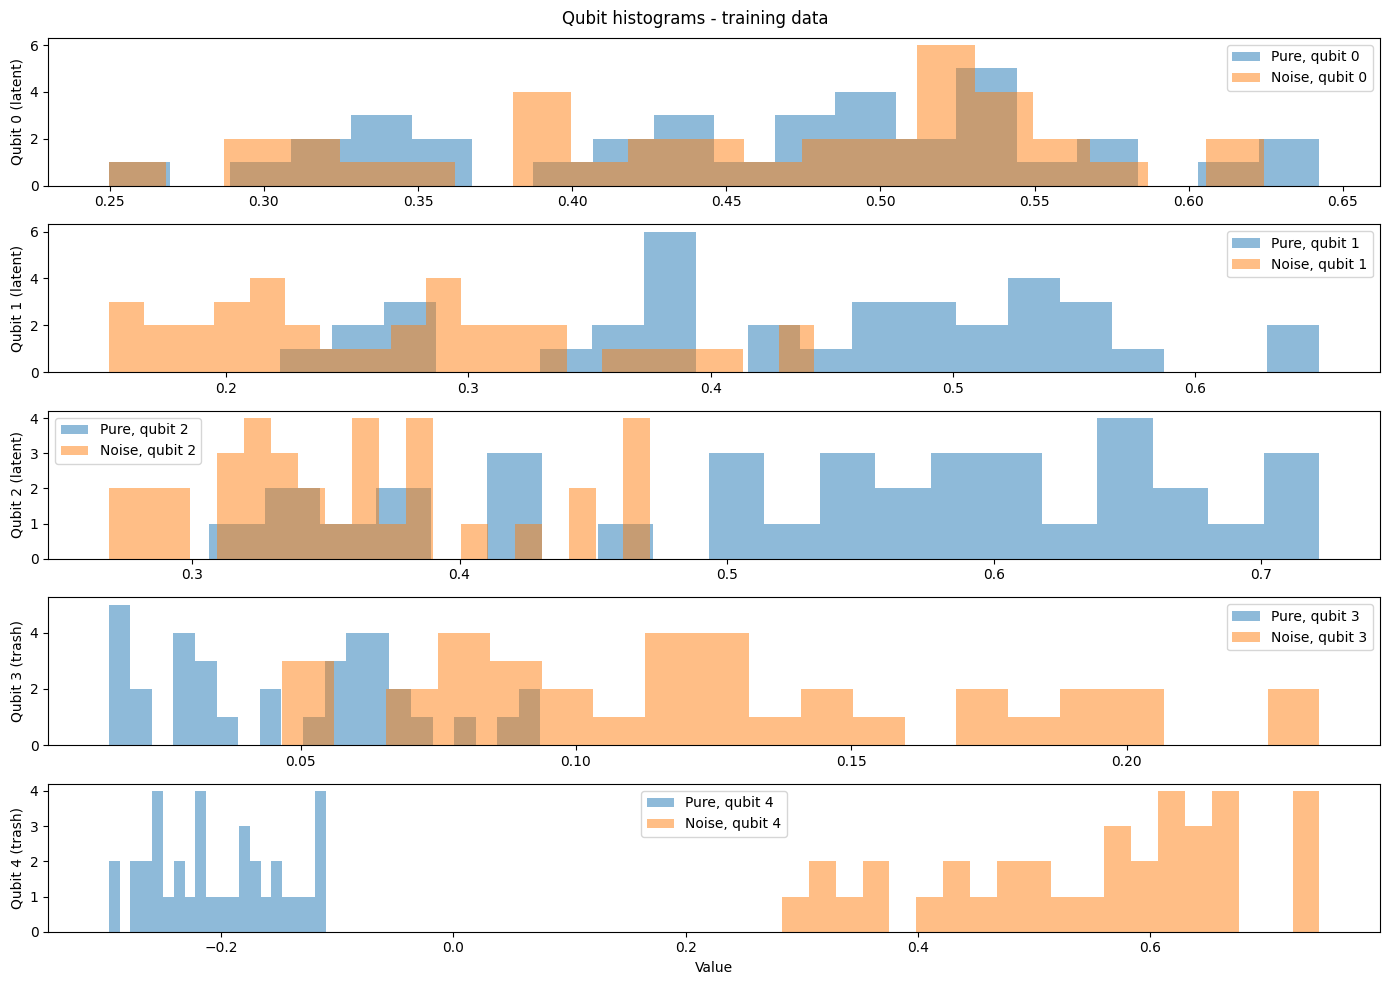

In [20]:
_, y_train_tens, _, _ = create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)
plot_qubit_histograms(
    half_qae_model_unified_pure,
    half_qae_model_unified_noise,
    best_params_pure,
    best_params_noise,
    y_train_tens,
    n_latent,
    title="Qubit histograms - training data"
)

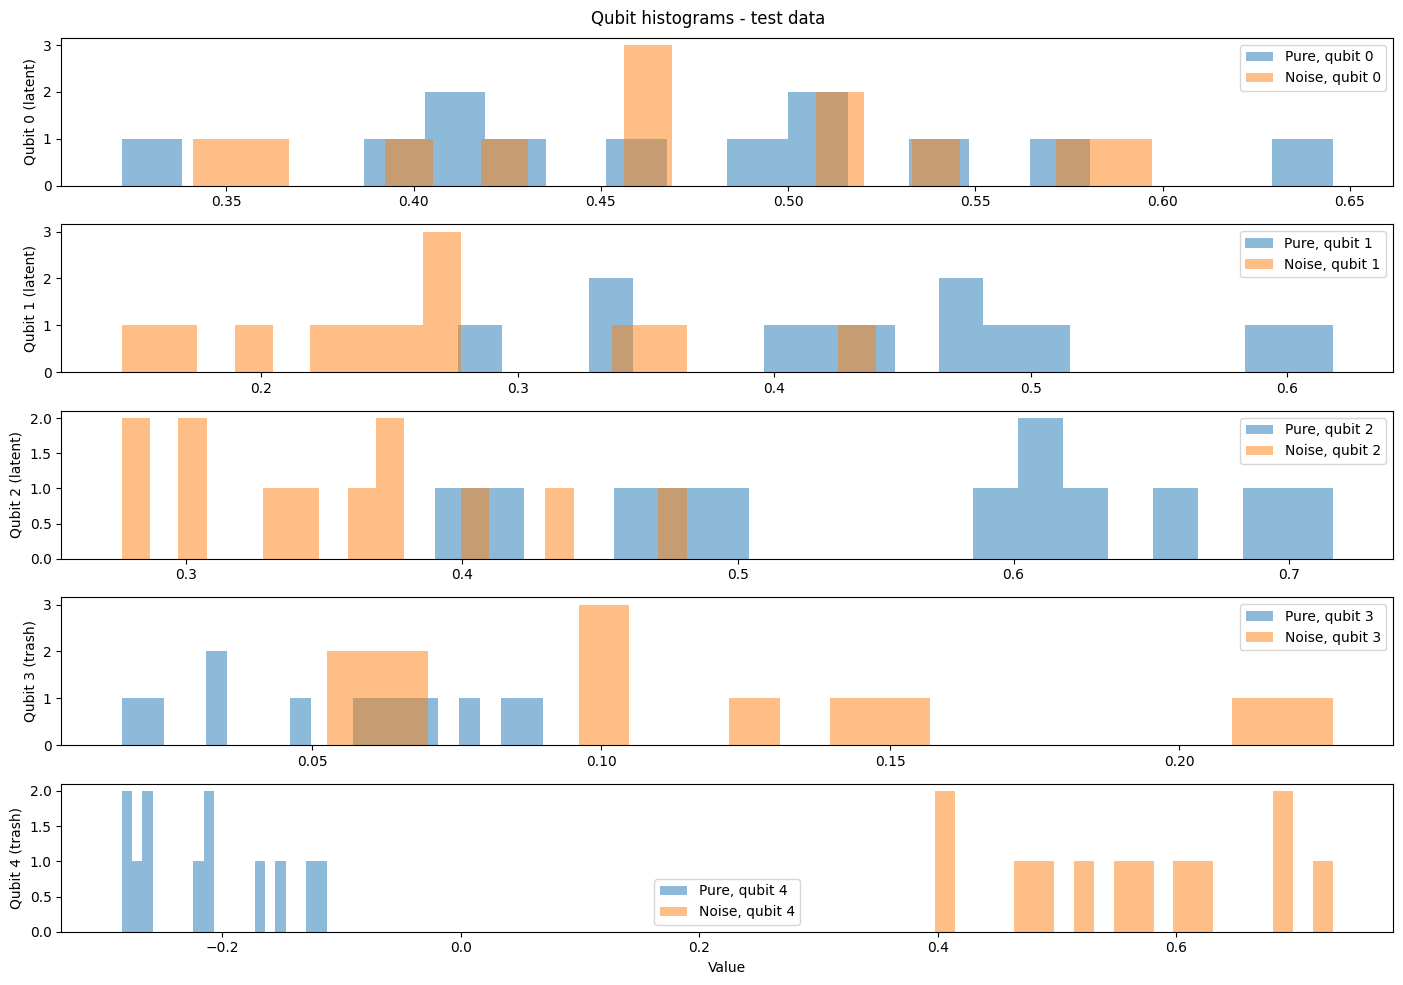

In [21]:
_, _, _, y_test_tens = create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)
plot_qubit_histograms(
    half_qae_model_unified_pure,
    half_qae_model_unified_noise,
    best_params_pure,
    best_params_noise,
    y_test_tens,
    n_latent,
    title="Qubit histograms - test data"
)

In [22]:

output_clean = np.array([half_qae_model_unified_pure(best_params_pure, window) for window in y_test_tens])
output_noise = np.array([half_qae_model_unified_noise(best_params_noise, window) for window in y_test_tens])


z_clean = output_clean[:, :n_latent]
z_noisy = output_noise[:, :n_latent]

# Calculate MSE
mse_latent = np.mean((z_clean - z_noisy) ** 2)
print(f"MSE between latent qubits (clean vs denoised): {mse_latent:.6f}")

MSE between latent qubits (clean vs denoised): 0.029624


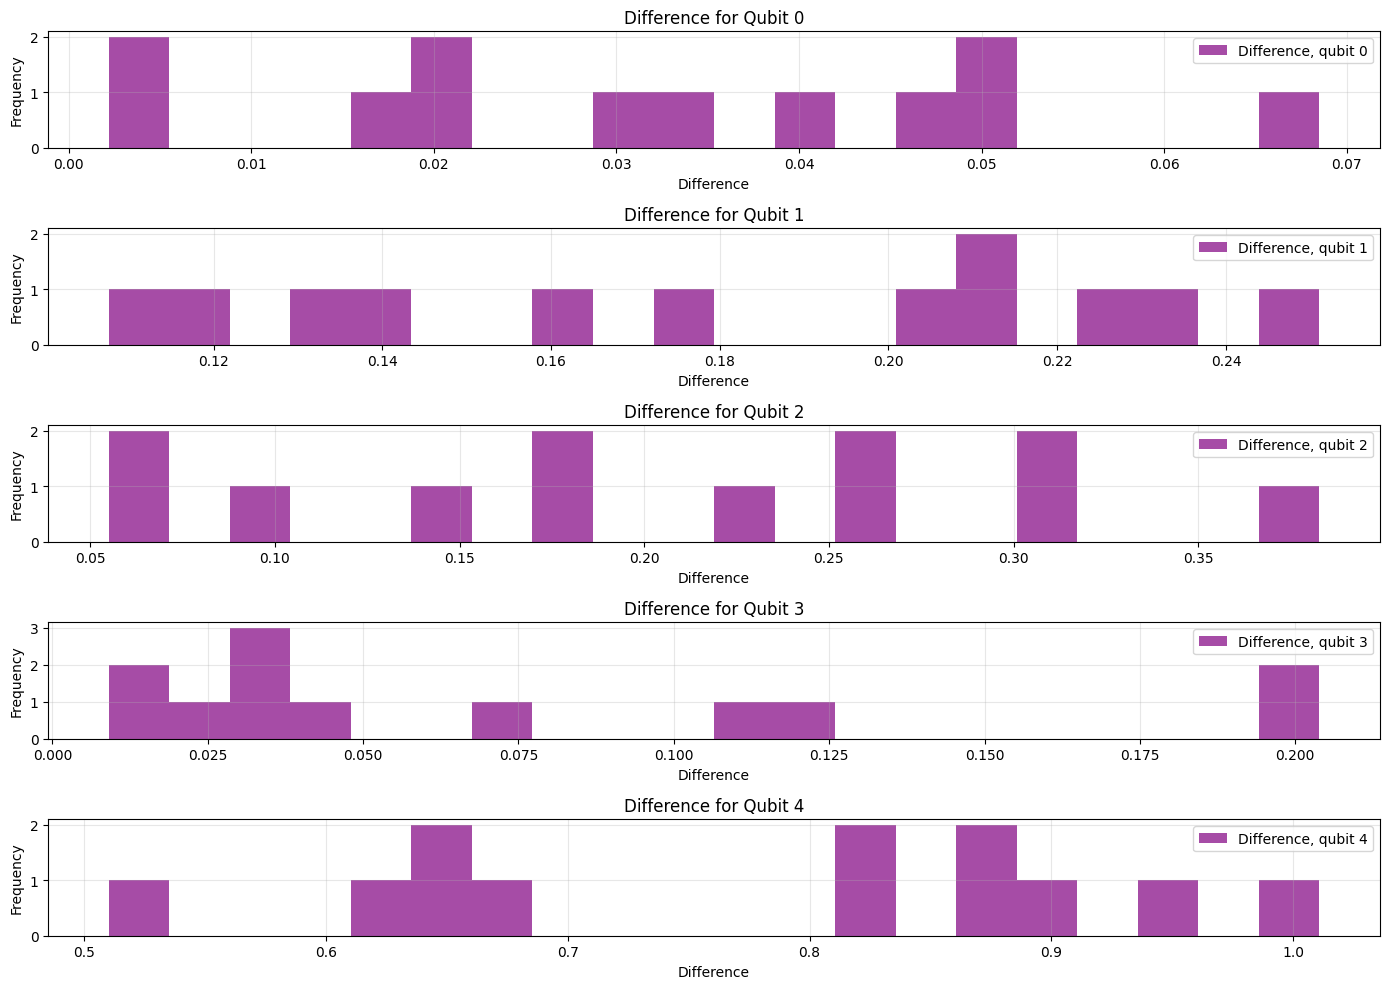

In [23]:
_, _, _, y_test_tens = create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)
output_pure = np.array([half_qae_model_unified_pure(best_params_pure, window) for window in y_test_tens])
output_noise = np.array([half_qae_model_unified_noise(best_params_noise, window) for window in y_test_tens])


output_diff = np.abs(output_pure - output_noise)

n_qubits = output_pure.shape[1]

plt.figure(figsize=(14, 2 * n_qubits))
for i in range(n_qubits):
    plt.subplot(n_qubits, 1, i + 1)
    plt.hist(output_diff[:, i], bins=20, alpha=0.7, color='purple', label=f'Difference, qubit {i}')
    plt.title(f'Difference for Qubit {i}')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

📊 Latent Stability Analysis:
   - Latent std devs: [0.03203322 0.03442686 0.03327331 0.02499294 0.03504983]
   - Stability score: 0.969 (>0.8 = Good)


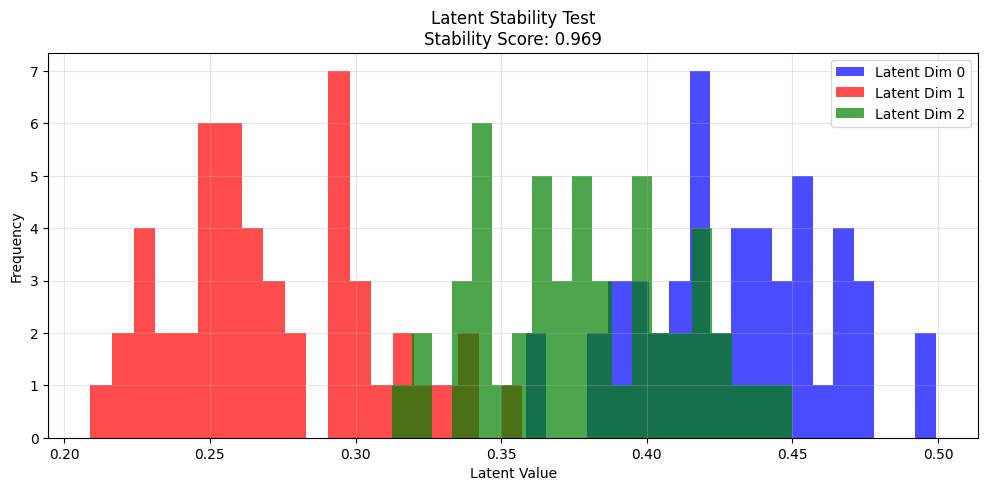

In [24]:
# Latent Space Stability Analysis
def test_latent_stability(enc_params, n_tests=50):
    """Test if encoder produces consistent latent representations"""

    qae_noise = half_qae_unified(wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=False)
    dev_noise = qml.device(sim, wires=wires, shots=shots, seed=seed)
    half_qae_model_unified_noise = qml.QNode(qae_noise, dev_noise)
    
    # Test on multiple samples with same noise level
    test_sample = y_test_tens[0]
    latent_variations = []
    
    for _ in range(n_tests):
        noisy_sample = ts_add_noise(test_sample, noise)
        latent = half_qae_model_unified_noise(enc_params, noisy_sample)
        latent_variations.append(latent)
    
    latent_array = np.array(latent_variations)
    
    # Calculate stability metrics
    latent_std = np.std(latent_array, axis=0)
    latent_mean = np.mean(latent_array, axis=0)
    stability_score = 1.0 / (1.0 + np.mean(latent_std))
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    plt.hist(latent_array[:, 0], bins=20, alpha=0.7, label='Latent Dim 0', color='blue')
    plt.hist(latent_array[:, 1], bins=20, alpha=0.7, label='Latent Dim 1', color='red')
    plt.hist(latent_array[:, 2], bins=20, alpha=0.7, label='Latent Dim 2', color='green')
    plt.xlabel('Latent Value')
    plt.ylabel('Frequency')
    plt.title(f'Latent Stability Test\nStability Score: {stability_score:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    
    print(f"📊 Latent Stability Analysis:")
    print(f"   - Latent std devs: {latent_std}")
    print(f"   - Stability score: {stability_score:.3f} (>0.8 = Good)")
    
    return stability_score

# Test latent stability
stability_score = test_latent_stability(best_params_noise)

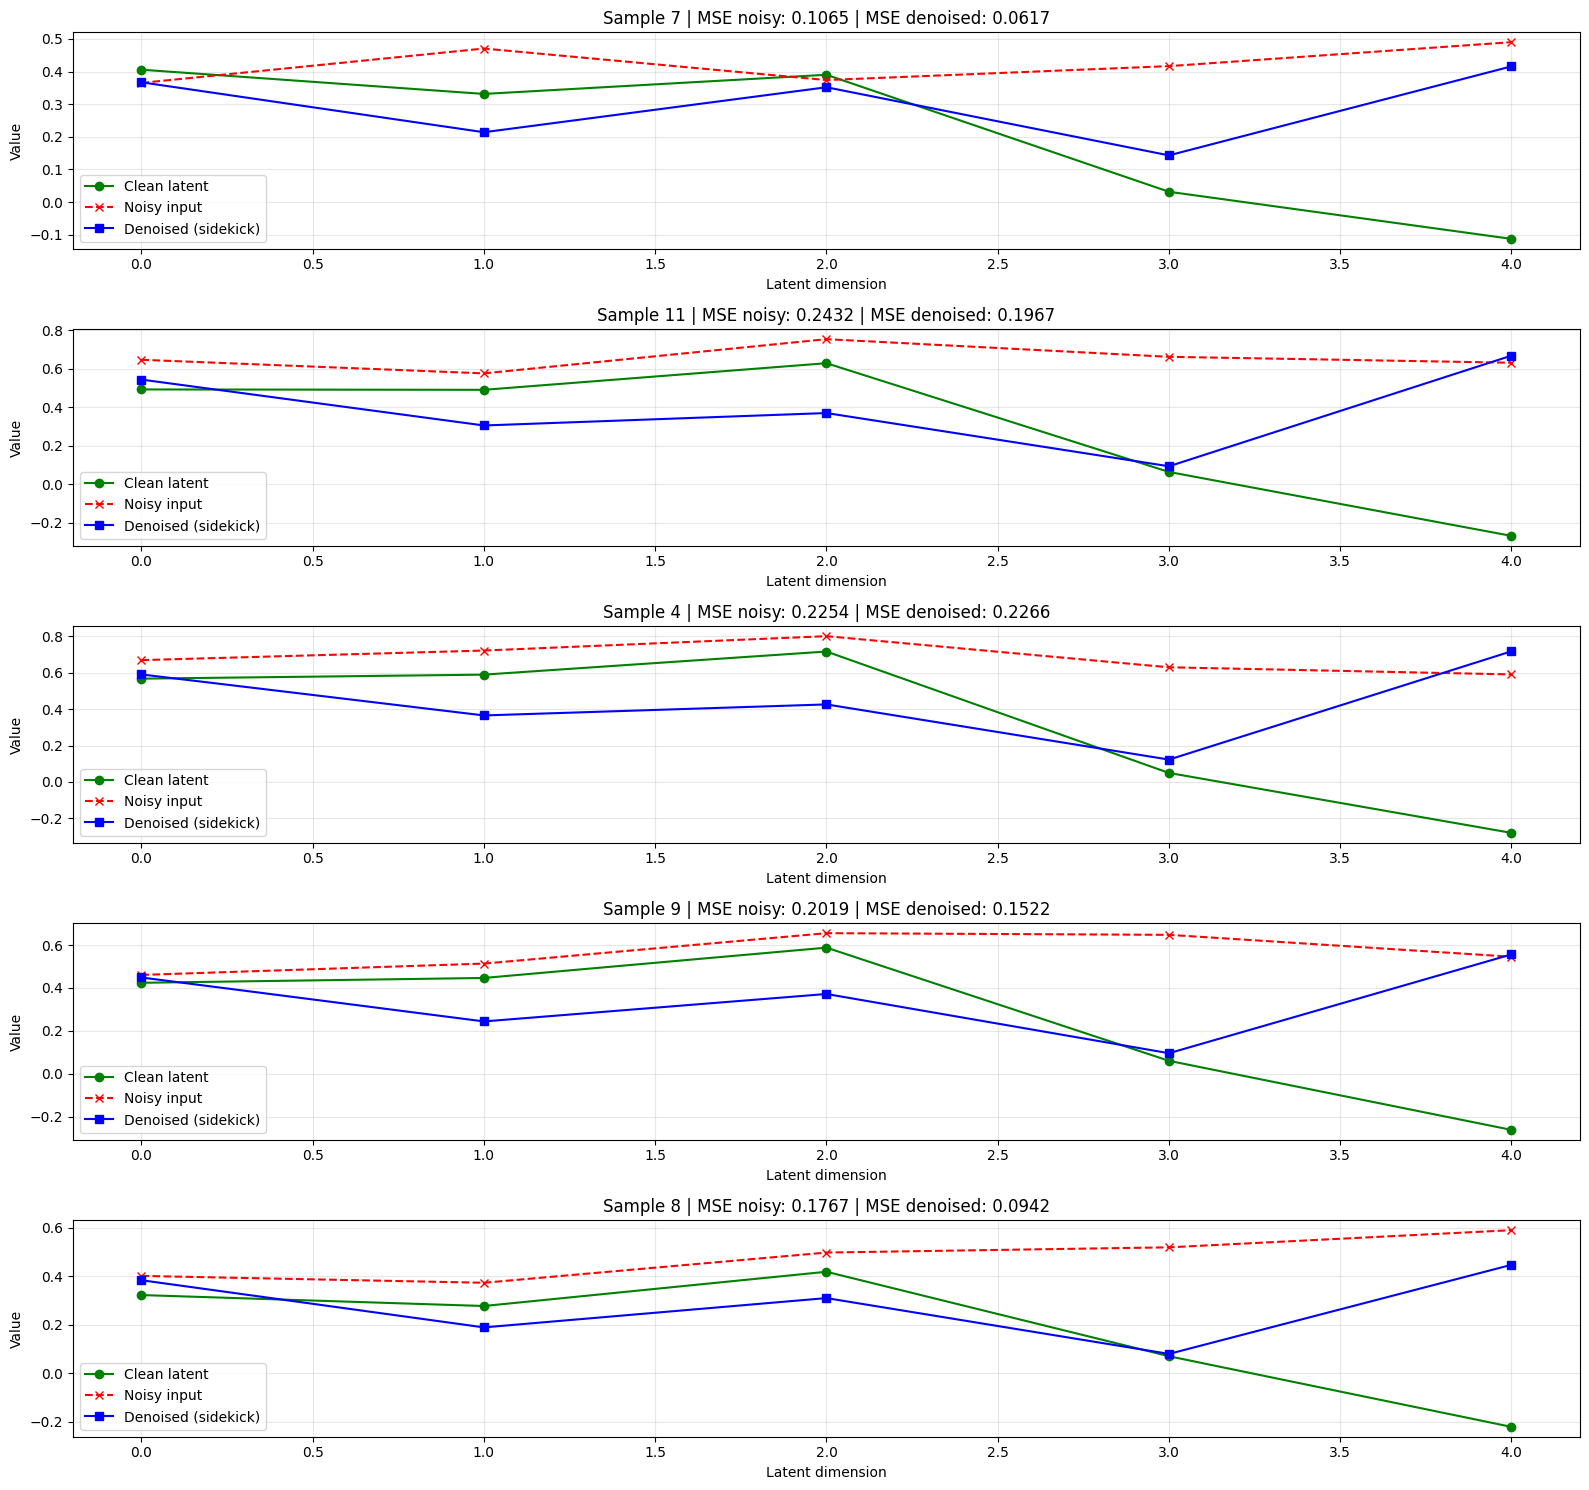

In [25]:
def plot_sidekick_samples(model_pure, model_noise, params_pure, params_noise, y_test_tens, n_latent, noise_level=0.1, n_samples=5):
    """
    Plot for 5 random samples: clean, noisy, denoised (sidekick), with MSE for each sample.
    """
    idxs = np.random.choice(len(y_test_tens), n_samples, replace=False)
    plt.figure(figsize=(16, 3 * n_samples))
    for i, idx in enumerate(idxs):
        clean = y_test_tens[idx]
        noisy = ts_add_noise(clean, noise_level)
        denoised = np.array(model_noise(params_noise, noisy))
        clean_latent = np.array(model_pure(params_pure, clean))
        mse_noisy = np.mean((clean_latent - np.array(noisy)) ** 2)
        mse_denoised = np.mean((clean_latent - denoised) ** 2)
        plt.subplot(n_samples, 1, i+1)
        plt.plot(clean_latent, 'o-', label='Clean latent', color='green')
        plt.plot(np.array(noisy), 'x--', label='Noisy input', color='red')
        plt.plot(denoised, 's-', label='Denoised (sidekick)', color='blue')
        plt.title(f'Sample {idx} | MSE noisy: {mse_noisy:.4f} | MSE denoised: {mse_denoised:.4f}')
        plt.xlabel('Latent dimension')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_sidekick_samples(
    half_qae_model_unified_pure,
    half_qae_model_unified_noise,
    best_params_pure,
    best_params_noise,
    y_test_tens,
    n_latent,
    noise_level=noise
)

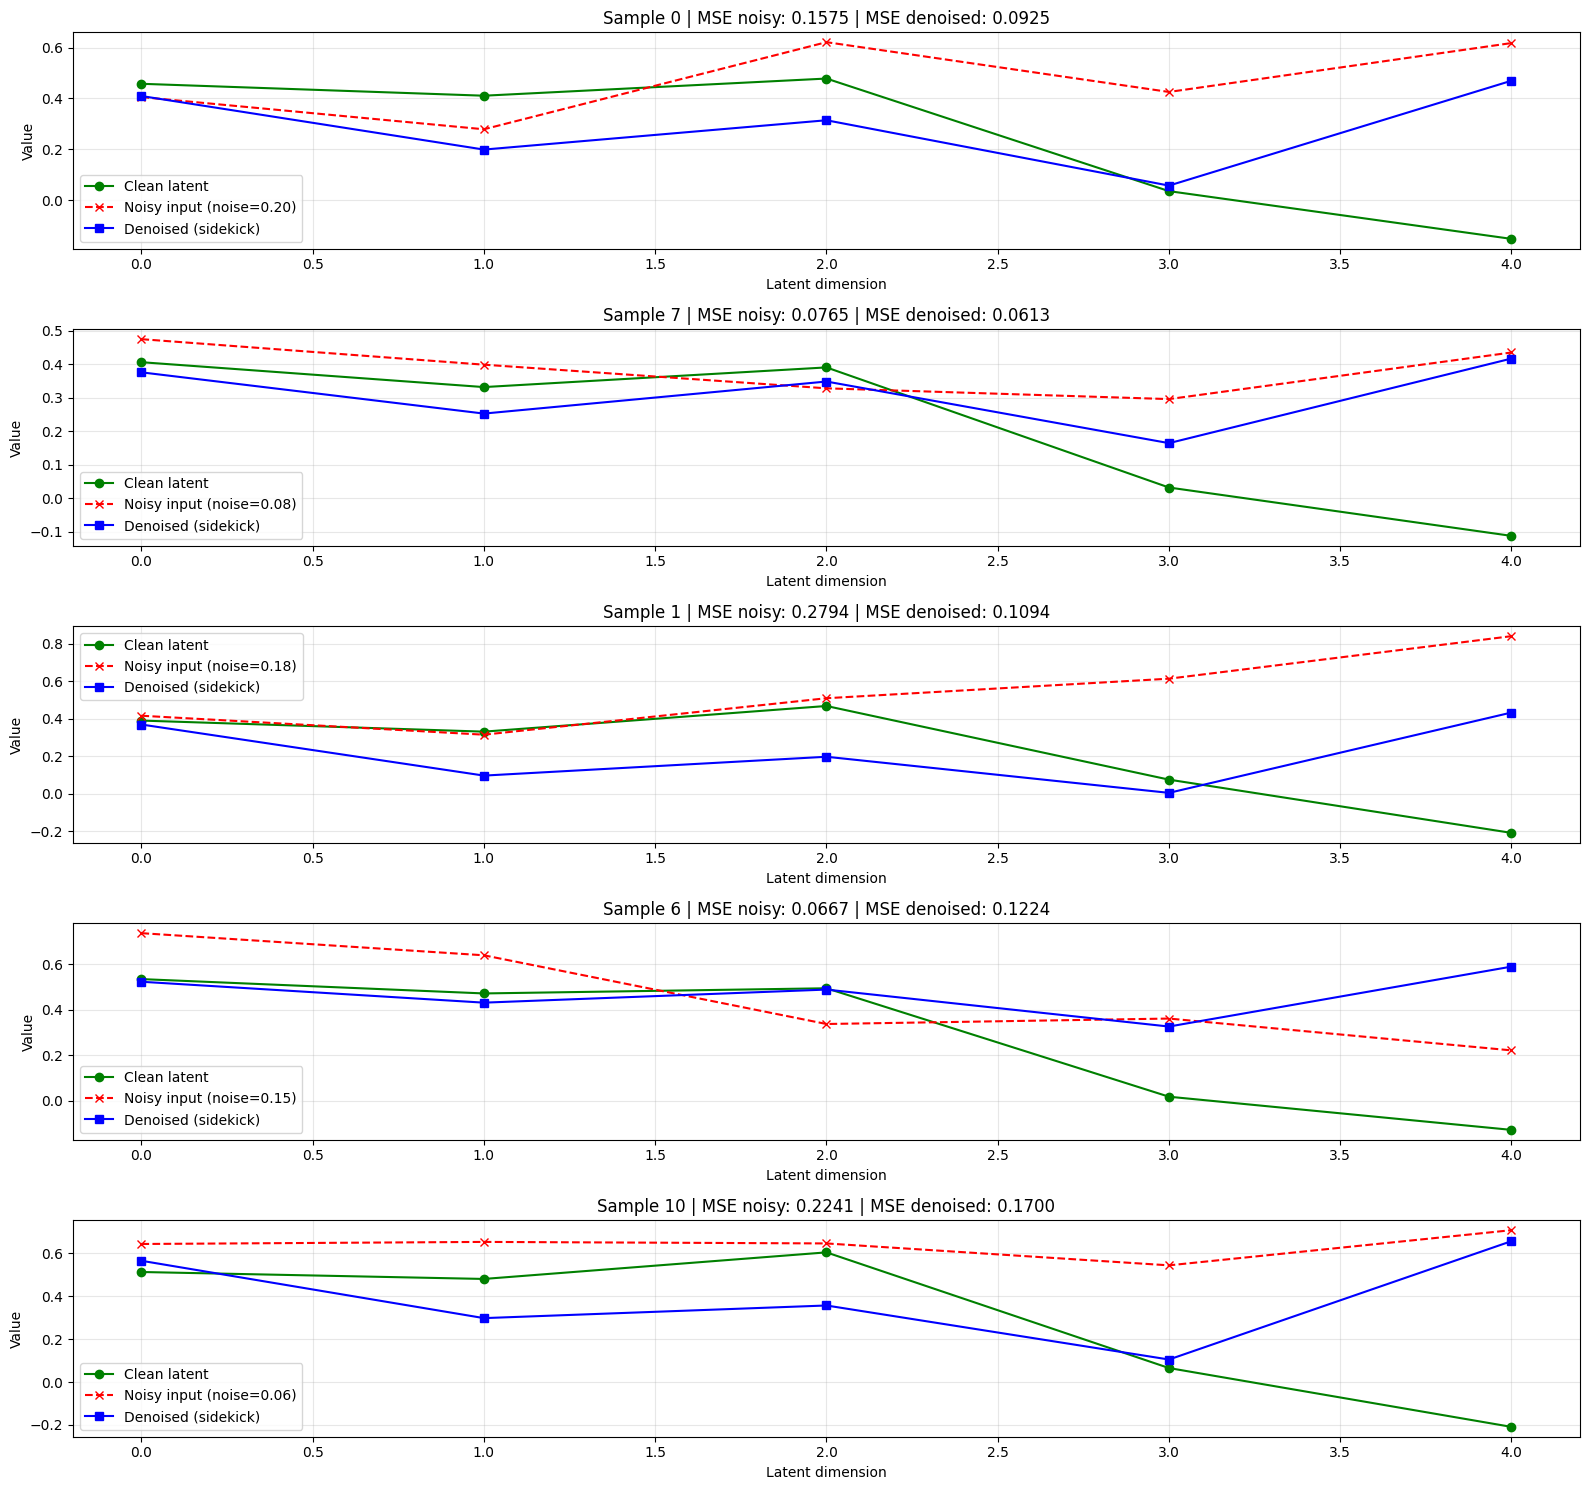

In [26]:
def plot_sidekick_samples_random_noise(model_pure, model_noise, params_pure, params_noise, y_test_tens, n_latent, noise_min=0.01, noise_max=0.2, n_samples=5):
    """
    Plot for 5 random samples: clean, noisy (with random noise), denoised (sidekick), with MSE for each sample.
    """
    idxs = np.random.choice(len(y_test_tens), n_samples, replace=False)
    plt.figure(figsize=(16, 3 * n_samples))
    for i, idx in enumerate(idxs):
        clean = y_test_tens[idx]
        noise_level = np.random.uniform(noise_min, noise_max)
        noisy = ts_add_noise(clean, noise_level)
        denoised = np.array(model_noise(params_noise, noisy))
        clean_latent = np.array(model_pure(params_pure, clean))
        mse_noisy = np.mean((clean_latent - np.array(noisy)) ** 2)
        mse_denoised = np.mean((clean_latent - denoised) ** 2)
        plt.subplot(n_samples, 1, i+1)
        plt.plot(clean_latent, 'o-', label='Clean latent', color='green')
        plt.plot(np.array(noisy), 'x--', label=f'Noisy input (noise={noise_level:.2f})', color='red')
        plt.plot(denoised, 's-', label='Denoised (sidekick)', color='blue')
        plt.title(f'Sample {idx} | MSE noisy: {mse_noisy:.4f} | MSE denoised: {mse_denoised:.4f}')
        plt.xlabel('Latent dimension')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_sidekick_samples_random_noise(
    half_qae_model_unified_pure,
    half_qae_model_unified_noise,
    best_params_pure,
    best_params_noise,
    y_test_tens,
    n_latent,
    noise_min=0.01,
    noise_max=0.2,
    n_samples=5
)

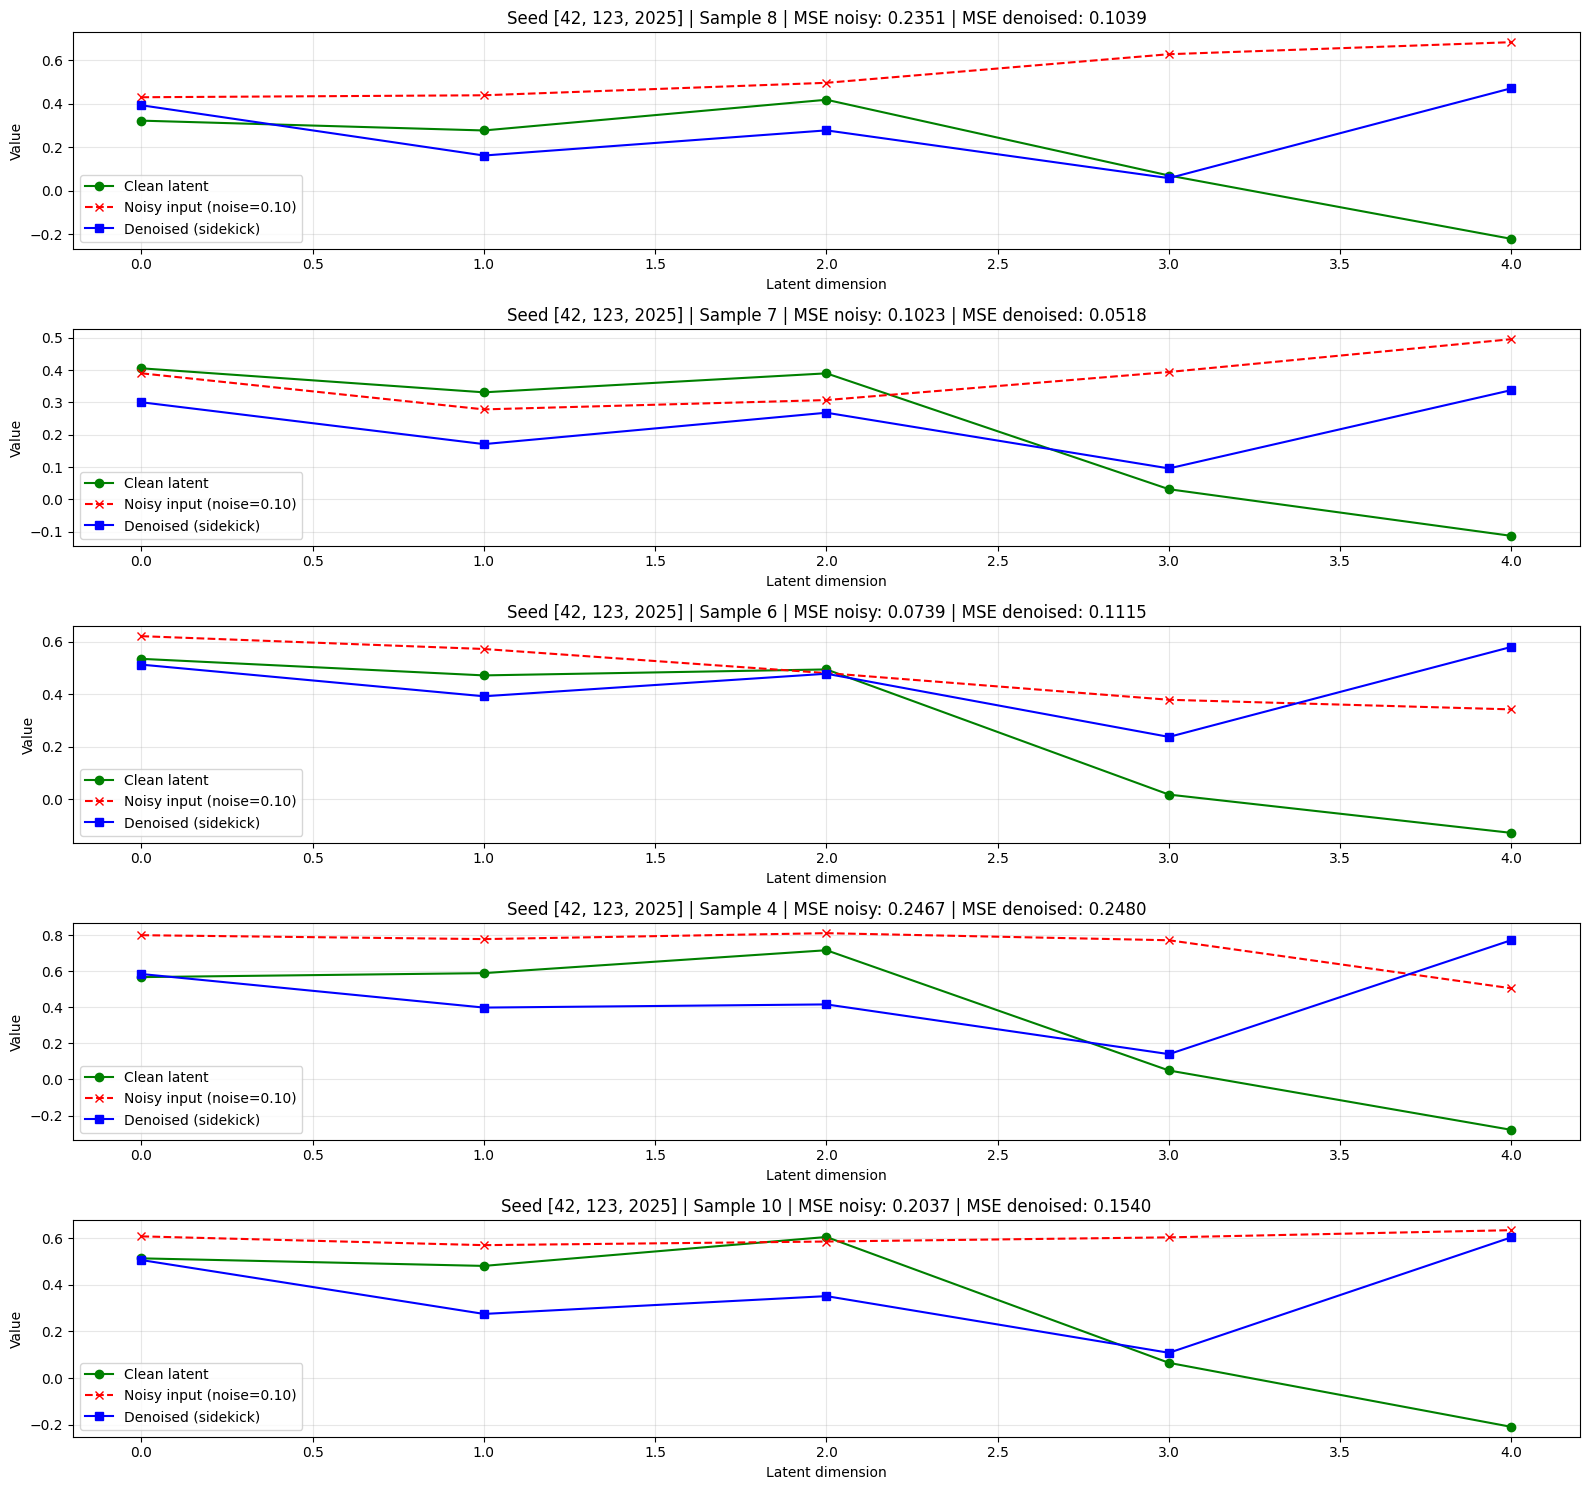

In [27]:
def plot_sidekick_samples_with_seed(
    model_pure, model_noise, params_pure, params_noise, y_test_tens, n_latent,
    noise_level=0.1, n_samples=5, seed=42
):
    """
    Plot for 5 random samples (with fixed seed): clean, noisy, denoised (sidekick), with MSE for each sample.
    """
    np.random.seed(seed)
    idxs = np.random.choice(len(y_test_tens), n_samples, replace=False)
    plt.figure(figsize=(16, 3 * n_samples))
    for i, idx in enumerate(idxs):
        clean = y_test_tens[idx]
        noisy = ts_add_noise(clean, noise_level)
        denoised = np.array(model_noise(params_noise, noisy))
        clean_latent = np.array(model_pure(params_pure, clean))
        mse_noisy = np.mean((clean_latent - np.array(noisy)) ** 2)
        mse_denoised = np.mean((clean_latent - denoised) ** 2)
        plt.subplot(n_samples, 1, i+1)
        plt.plot(clean_latent, 'o-', label='Clean latent', color='green')
        plt.plot(np.array(noisy), 'x--', label=f'Noisy input (noise={noise_level:.2f})', color='red')
        plt.plot(denoised, 's-', label='Denoised (sidekick)', color='blue')
        plt.title(f'Seed {seed} | Sample {idx} | MSE noisy: {mse_noisy:.4f} | MSE denoised: {mse_denoised:.4f}')
        plt.xlabel('Latent dimension')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_sidekick_samples_with_seed(
    half_qae_model_unified_pure,
    half_qae_model_unified_noise,
    best_params_pure,
    best_params_noise,
    y_test_tens,
    n_latent,
    noise_level=0.1,
    n_samples=5,
    seed=[42,123,2025]
)